In [113]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np 
pd.set_option('float_format', '{:f}'.format)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 

plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

import requests
from tqdm import tqdm, tqdm_notebook

# Data Load 

In [12]:
# 온라인 구매 이력
# 날짜, 성별, 연령대, 큰 카테고리, 작은 카테고리, 구매량
buy2018_1 = pd.read_csv('buy2018_1.csv', encoding='cp949')
buy2018_2 = pd.read_csv('buy2018_2.csv', encoding='cp949') 
buy2019_1 = pd.read_csv('buy2019_1.csv', encoding='cp949') 
buy2019_2 = pd.read_csv('buy2019_2.csv', encoding='cp949')

buy2018_1 = buy2018_1.iloc[:,1:]
buy2018_2 = buy2018_2.iloc[:,1:]
buy2019_1 = buy2019_1.iloc[:,1:]
buy2019_2 = buy2019_2.iloc[:,1:]

buy2018_1.columns = ['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']
buy2018_2.columns = ['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']
buy2019_1.columns = ['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']
buy2019_2.columns = ['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']

In [13]:
buy2018_1.head()

,date,sex,age,big_cat,sm_cat,qty
0,20180101,F,20,식품,가공란,37
1,20180101,F,30,식품,가공란,16
2,20180101,F,40,식품,가공란,9
3,20180101,F,50,식품,가공란,3
4,20180101,M,20,식품,가공란,13


In [14]:
# 소셜 데이터 
# 날짜, 큰 카테고리, 작은 카테고리, 구매량
sns2018_1 = pd.read_csv('sns2018_1.csv', encoding='cp949') 
sns2018_2 = pd.read_csv('sns2018_2.csv', encoding='cp949') 
sns2019_1 = pd.read_csv('sns2019_1.csv', encoding='cp949') 
sns2019_2 = pd.read_csv('sns2019_2.csv', encoding='cp949')

sns2018_1 = sns2018_1.iloc[:,1:]
sns2018_2 = sns2018_2.iloc[:,1:]
sns2019_1 = sns2019_1.iloc[:,1:]
sns2019_2 = sns2019_2.iloc[:,1:]

sns2018_1.columns = ['date', 'big_cat', 'sm_cat', 'cnt']
sns2018_2.columns = ['date', 'big_cat', 'sm_cat', 'cnt']
sns2019_1.columns = ['date', 'big_cat', 'sm_cat', 'cnt']
sns2019_2.columns = ['date', 'big_cat', 'sm_cat', 'cnt']

In [15]:
sns2018_1.head()

,date,big_cat,sm_cat,cnt
0,20180101,뷰티,기능성 링클케어 화장품,12.154295
1,20180101,뷰티,기능성 모공관리 화장품,36.000828
2,20180101,뷰티,기능성 아이케어 화장품,0.895782
3,20180101,뷰티,기능성 영양보습 화장품,14.868175
4,20180101,뷰티,기능성 트러블케어 화장품,48.819391


In [19]:
buy = pd.concat([buy2018_1, buy2018_2, buy2019_1, buy2019_2], axis=0, ignore_index = True)
sns = pd.concat([sns2018_1, sns2018_2, sns2019_1, sns2019_2], axis=0, ignore_index = True)

buy.shape, sns.shape

((2056899, 6), (279590, 4))

In [21]:
df = buy.merge(sns, how='left', on=['date', 'big_cat', 'sm_cat'])

print(df.shape)
df.head()

(2056899, 7)


,date,sex,age,big_cat,sm_cat,qty,cnt
0,20180101,F,20,식품,가공란,37,0.480964
1,20180101,F,30,식품,가공란,16,0.480964
2,20180101,F,40,식품,가공란,9,0.480964
3,20180101,F,50,식품,가공란,3,0.480964
4,20180101,M,20,식품,가공란,13,0.480964


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056899 entries, 0 to 2056898
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   date     int64  
 1   sex      object 
 2   age      int64  
 3   big_cat  object 
 4   sm_cat   object 
 5   qty      int64  
 6   cnt      float64
dtypes: float64(1), int64(3), object(3)
memory usage: 125.5+ MB


In [23]:
df.isnull().sum()

date       0
sex        0
age        0
big_cat    0
sm_cat     0
qty        0
cnt        0
dtype: int64

# Datetime Preprocessing 

In [28]:
tqdm.pandas()
df["date"] = df['date'].progress_apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

100%|██████████| 2056899/2056899 [02:24<00:00, 14219.73it/s]


In [30]:
# 날짜 관련 변수 생성 
df["year"] = df['date'].dt.year
df["month"] = df['date'].dt.month
df["day"] = df['date'].dt.day

df["quarter"] = df['date'].dt.quarter # 분기 
df['weekday']  = df['date'].dt.weekday # 요일 (weekday_day : 요일 이름)

In [31]:
def getHoliday(year):
    
    '''
    공공데이터포털 공휴일 정보 OPEN API  
    '''
    
    url = f'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?solYear={year}&ServiceKey={key}&_type=json&numOfRows=20'
    response = requests.get(url)
    holidays = response.json()['response']['body']['items']['item']
    holidays = pd.DataFrame(holidays)
    holidays['locdate'] = holidays['locdate'].astype(str).apply(lambda x : '-'.join([x[:4], x[4:6], x[6:]]))
    
    return holidays

In [32]:
key = '8H1yac%2Bb0yetY2Waad%2BQIRU43O17onRUd7iR0k2p6%2B4i0yNYn3ym0cXgt3ZqWrR9uFw%2BDu%2B5quHbsXxjpsw5ng%3D%3D'

In [40]:
# 공휴일 
holidays2018 = getHoliday(2018)
holidays2019 = getHoliday(2019)

holidays = pd.concat([holidays2018, holidays2019], axis=0, ignore_index = True)

In [42]:
holidays["locdate"] = holidays['locdate'].progress_apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

df = df.merge(holidays[['locdate', 'isHoliday']], left_on = 'date', right_on = 'locdate', how = 'left').drop('locdate', axis = 1)
df['isHoliday'] = df['isHoliday'].progress_apply(lambda x : 1 if x == 'Y' else 0)

# 주말 : 월 0 화 1 수 2 목 3 금 4 토 5 일 6 
df["weekend"] = df["weekday"].progress_apply(lambda x : 1 if x in [5,6] else 0)

100%|██████████| 2056899/2056899 [00:01<00:00, 1117230.81it/s]


In [47]:
# 계절 : 봄 0 여름 1 가을 2 겨울 3 
df["season"] = df["month"].progress_apply(lambda x : 0 if x in [3,4,5] 
                                                     else 1 if x in [6,7,8] 
                                                     else 2 if x in [9,10,11]
                                                     else 3)

100%|██████████| 2056899/2056899 [00:01<00:00, 1056736.18it/s]


In [49]:
print(df.shape)
df.head()

(2056899, 15)


,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
0,2018-01-01,F,20,식품,가공란,37,0.480964,2018,1,1,1,0,1,0,3
1,2018-01-01,F,30,식품,가공란,16,0.480964,2018,1,1,1,0,1,0,3
2,2018-01-01,F,40,식품,가공란,9,0.480964,2018,1,1,1,0,1,0,3
3,2018-01-01,F,50,식품,가공란,3,0.480964,2018,1,1,1,0,1,0,3
4,2018-01-01,M,20,식품,가공란,13,0.480964,2018,1,1,1,0,1,0,3


# EDA

## 1. qty

In [81]:
# Q3 까지 17 ...
df[['qty']].describe()

,qty
count,2056899.000000
mean,19.103396
std,43.972335
min,1.000000
25%,2.000000
50%,6.000000
75%,17.000000
max,2774.000000


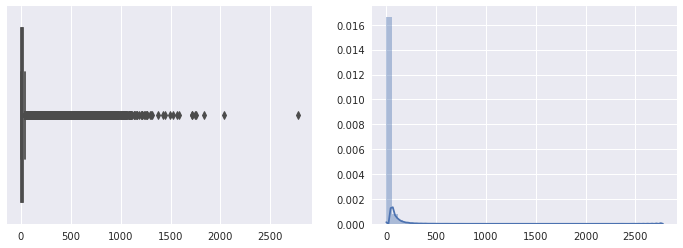

In [76]:
# qty 분포 : 당연하게도 왼쪽에 매우 매우 몰려 있음 ~ 
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(df[['qty']], ax=ax1)
sns.distplot(df[['qty']], ax=ax2)

plt.show()

In [78]:
# 많이 팔린 것들 뭘까 ~ : 스킨케어 수면팩, 마스크팩, 생수, 카페푸드 등등 & 대부분 나이대 30대 
df.sort_values("qty", ascending=False).head(20)

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
1498733,2019-06-20,M,30,뷰티,스킨케어 수면팩,2774,2.744000,2019,6,20,2,3,0,0,1
1777139,2019-09-26,M,30,뷰티,베이스 메이크업용 쿠션팩트,2034,6.897365,2019,9,26,3,3,0,0,2
1774731,2019-09-25,F,20,뷰티,스킨케어 마스크팩,1839,41.678505,2019,9,25,3,2,0,0,2
1352862,2019-05-01,F,40,뷰티,베이스 메이크업용 메이크업베이스,1759,13.511000,2019,5,1,2,2,0,0,0
1379759,2019-05-10,F,30,식품,생수,1742,37.805675,2019,5,10,2,4,0,0,0
1223773,2019-03-18,F,30,뷰티,기초 화장용 에센스,1718,74.495082,2019,3,18,1,0,0,0,0
2021029,2019-12-19,M,30,뷰티,스킨케어 수면팩,1711,1.391644,2019,12,19,4,3,0,0,3
1414643,2019-05-22,F,30,식품,생수,1585,44.288064,2019,5,22,2,2,0,0,0
389641,2018-05-22,F,30,식품,생수,1561,35.448670,2018,5,22,2,1,1,0,0
371041,2018-05-15,F,30,식품,커피음료,1525,1.363084,2018,5,15,2,1,0,0,0


In [88]:
# 많이 팔린 물품 (500 이상) vs 적당히 팔린 물품 (20 이하) 나눠서 체크! 
qty_normal = df[df["qty"] <= 20]
qty_over = df[df["qty"] >= 500]

qty_normal.shape, qty_over.shape

((1620621, 15), (2232, 15))

### 1) 적당히 팔린 물품들

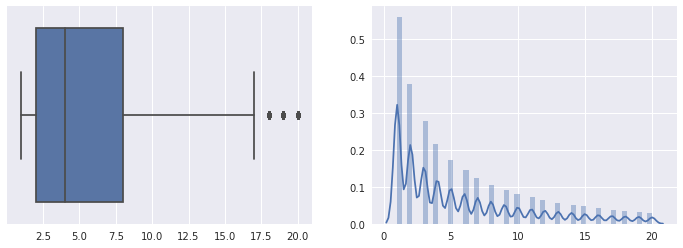

In [89]:
# qty 분포
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(qty_normal[['qty']], ax=ax1)
sns.distplot(qty_normal[['qty']], ax=ax2)

plt.show()

In [92]:
# 남성 스킨로션 ... 
qty_normal.sm_cat.value_counts()[:30]

남성 스킨            6797
남성 로션            6642
견과류 호두           6635
헤어스프레이           6604
한방재료             6589
녹차               6574
견과류 땅콩           6539
글루코사민/키토산 영양제    6525
양파/마늘즙           6467
남성 세트            6422
환자식              6408
남성 에센스           6398
인삼/수삼/산삼         6398
남성 쉐이빙           6353
건어물 황태           6335
비타민/화이바 음료       6307
차/곡물 음료          6287
식혜/수정과           6267
음용 식초            6218
홍삼절편/홍삼정과        6166
과실차              6162
건강즙              6151
홍차               6144
나물               6139
마늘/생강            6115
수입우육             6091
헤어스타일링용 흑채       6058
건어물 멸치           6048
해조류 미역           6044
뷰티용 면봉/귀이개       6040
Name: sm_cat, dtype: int64

#### (1) count 제일 많이 찍힌 남성 스킨

In [95]:
# 남성 스킨로션이지만 남성이 구매하지는 않는 듯 .. 
qty_normal[qty_normal['sm_cat'] == '남성 스킨'].sort_values("qty", ascending=False).head(15)

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
410833,2018-05-30,F,40,뷰티,남성 스킨,20,122.570919,2018,5,30,2,2,0,0,0
776162,2018-10-11,F,30,뷰티,남성 스킨,20,28.222182,2018,10,11,4,3,0,0,2
1284998,2019-04-08,F,40,뷰티,남성 스킨,20,14.402926,2019,4,8,2,0,0,0,0
1488683,2019-06-17,M,40,뷰티,남성 스킨,20,15.548099,2019,6,17,2,0,0,0,1
2040199,2019-12-26,F,30,뷰티,남성 스킨,20,10.389956,2019,12,26,4,3,0,0,3
160185,2018-02-28,F,30,뷰티,남성 스킨,20,56.905628,2018,2,28,1,2,0,0,3
45015,2018-01-17,F,40,뷰티,남성 스킨,20,18.452786,2018,1,17,1,2,0,0,3
1399288,2019-05-17,M,40,뷰티,남성 스킨,20,14.468380,2019,5,17,2,4,0,0,0
624570,2018-08-16,F,30,뷰티,남성 스킨,20,132.728391,2018,8,16,3,3,0,0,1
1223914,2019-03-18,F,40,뷰티,남성 스킨,19,17.450555,2019,3,18,1,0,0,0,0


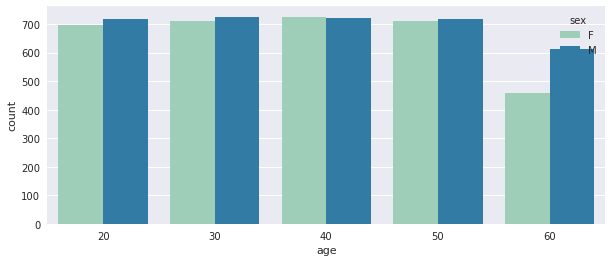

In [104]:
# (countplot) 남여 구매 비율 비슷! 
plt.figure(figsize = (10, 4))
sns.countplot(x="age", hue="sex", data=qty_normal[qty_normal['sm_cat'] == '남성 스킨'], palette="YlGnBu")
plt.show()

In [102]:
# qty 값 더해서 비교 
qty_normal[qty_normal['sm_cat'] == '남성 스킨'].groupby(['age', 'sex']).qty.sum().unstack()

sex,F,M
age,,
20,3078,3255
30,6011,5645
40,5779,5672
50,3330,3880
60,758,1514


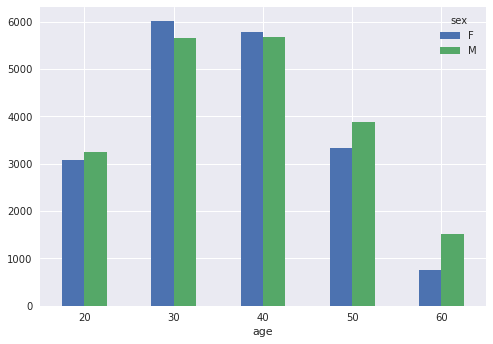

In [101]:
# 30/40대 남/여가 많이 구매 
qty_normal[qty_normal['sm_cat'] == '남성 스킨'].groupby(['age', 'sex']).qty.sum().unstack().plot.bar(rot=0)
plt.show()

#### (2) 녹차 

In [116]:
qty_normal[qty_normal['sm_cat'] == '녹차'].sort_values("qty", ascending=False).head()

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
1346408,2019-04-29,M,40,식품,녹차,20,88.274908,2019,4,29,2,0,0,0,0
1046406,2019-01-15,F,40,식품,녹차,20,103.376696,2019,1,15,1,1,0,0,3
1297068,2019-04-12,M,50,식품,녹차,20,87.860508,2019,4,12,2,4,0,0,0
289439,2018-04-16,F,30,식품,녹차,20,77.706790,2018,4,16,2,0,0,0,0
98213,2018-02-05,F,30,식품,녹차,20,95.121641,2018,2,5,1,0,0,0,3


In [107]:
# 성연령별 녹차 구매 
qty_normal[qty_normal['sm_cat'] == '녹차'].groupby(['age', 'sex']).qty.sum().unstack()

sex,F,M
age,,
20,3916,1319
30,6813,4898
40,6489,5822
50,3159,4582
60,831,1793


In [109]:
# 계절별 녹차 구매 
qty_normal[qty_normal['sm_cat'] == '녹차'].groupby(['age', 'season']).qty.sum().unstack()

season,0,1,2,3
age,,,,
20,1398,1168,1257,1412
30,3132,2587,2792,3200
40,3266,2840,2872,3333
50,2215,1555,1765,2206
60,807,533,557,727


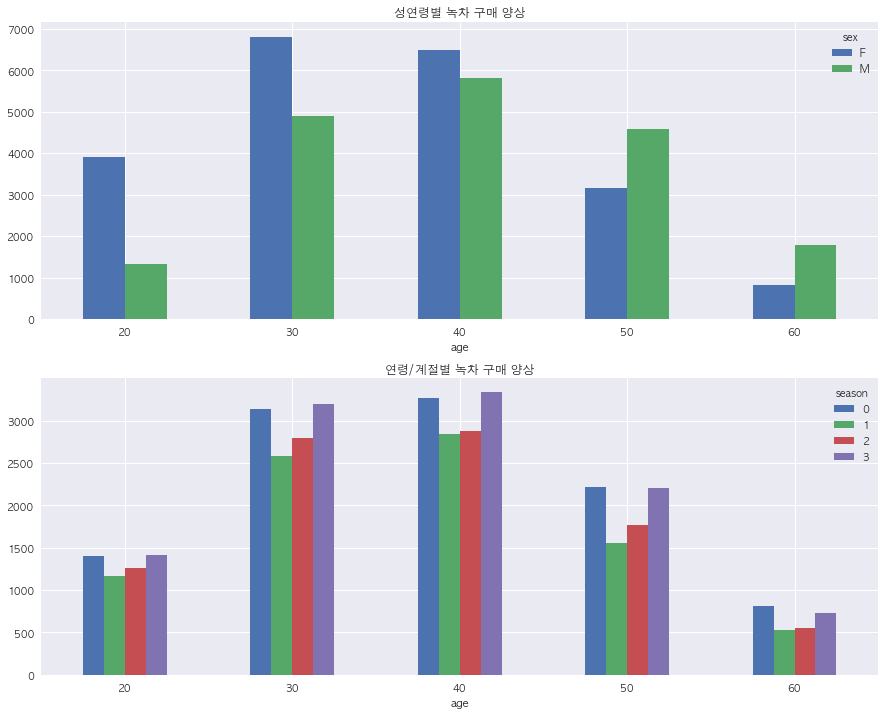

In [114]:
f, ax = plt.subplots(2, 1, figsize=(15,12))
qty_normal[qty_normal['sm_cat'] == '녹차'].groupby(['age', 'sex']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[0])
qty_normal[qty_normal['sm_cat'] == '녹차'].groupby(['age', 'season']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[1])

ax[0].set_title('성연령별 녹차 구매 양상')
ax[1].set_title('연령/계절별 녹차 구매 양상')

plt.show()

### 2) 많이 팔린 물품들 

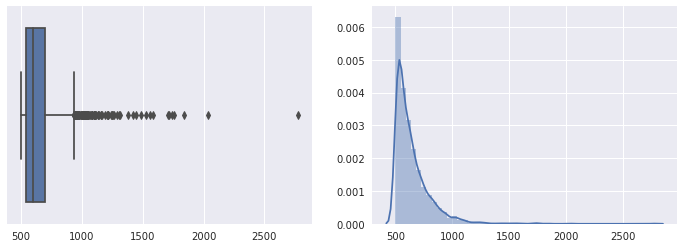

In [90]:
# qty 분포
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(qty_over[['qty']], ax=ax1)
sns.distplot(qty_over[['qty']], ax=ax2)

plt.show()

In [93]:
# 기초 화장용 크림, 커피음료, 생수, 샴푸
qty_over.sm_cat.value_counts()[:30]

기초 화장용 크림            895
커피음료                 524
생수                   306
샴푸                   105
기초 화장용 에센스            67
회                     59
감귤/한라봉/오렌지            37
네일 메이크업 용품            30
베이스 메이크업용 쿠션팩트        23
스킨케어 마스크팩             18
카페 푸드                 16
프로바이오틱스               14
유제품 음료                11
홍삼액/홍삼정               11
기능성 아이케어 화장품          10
돼지 곱창                  9
베이스 메이크업용 파운데이션        8
트리트먼트                  7
견과류                    7
한방 분말/환제품              7
공기청정기                  6
클렌징 폼                  5
베이스 메이크업용 메이크업베이스      5
스킨케어 수면팩               5
인스턴트커피                 4
곶감/반건시                 4
베이스 메이크업용 파우더팩트        4
배추김치                   3
토마토                    3
선크림                    2
Name: sm_cat, dtype: int64

#### (1) 기초 화장용 크림 

In [117]:
qty_over[qty_over['sm_cat'] == '기초 화장용 크림'].sort_values("qty", ascending=False).head()

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
1253056,2019-03-28,F,40,뷰티,기초 화장용 크림,1268,89.549681,2019,3,28,1,3,0,0,0
135193,2018-02-19,F,30,뷰티,기초 화장용 크림,1248,94.652670,2018,2,19,1,0,0,0,3
132506,2018-02-18,F,30,뷰티,기초 화장용 크림,1203,81.865769,2018,2,18,1,6,0,1,3
1253055,2019-03-28,F,30,뷰티,기초 화장용 크림,1167,89.549681,2019,3,28,1,3,0,0,0
1949403,2019-11-25,F,30,뷰티,기초 화장용 크림,1114,70.747856,2019,11,25,4,0,0,0,2


In [118]:
# 성연령별 기초 화장용 크림 구매 : 남자는 거의 구매 안 함 
qty_over[qty_over['sm_cat'] == '기초 화장용 크림'].groupby(['age', 'sex']).qty.sum().unstack()

sex,F,M
age,,
20,49875.000000,nan
30,375056.000000,1662.000000
40,169714.000000,nan
50,549.000000,nan


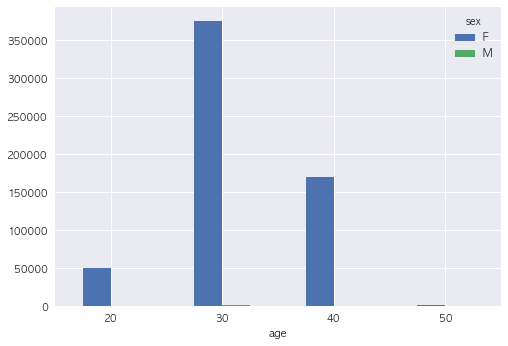

In [119]:
# 30대 여성이 많이 구매 
qty_over[qty_over['sm_cat'] == '기초 화장용 크림'].groupby(['age', 'sex']).qty.sum().unstack().plot.bar(rot=0)
plt.show()

#### (2) 커피 음료 

In [120]:
qty_over[qty_over['sm_cat'] == '커피음료'].sort_values("qty", ascending=False).head()

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
371041,2018-05-15,F,30,식품,커피음료,1525,1.363084,2018,5,15,2,1,0,0,0
1559603,2019-07-11,F,30,식품,커피음료,1444,1.190612,2019,7,11,3,3,0,0,1
1333685,2019-04-24,F,20,식품,커피음료,1259,2.651210,2019,4,24,2,2,0,0,0
1395076,2019-05-15,F,30,식품,커피음료,1212,2.125321,2019,5,15,2,2,0,0,0
1333690,2019-04-24,M,20,식품,커피음료,1083,2.651210,2019,4,24,2,2,0,0,0


In [121]:
# 성연령별 커피 음료 구매 : 여자 >> 남자 
qty_over[qty_over['sm_cat'] == '커피음료'].groupby(['age', 'sex']).qty.sum().unstack()

sex,F,M
age,,
20,104424,6780
30,192733,7812
40,5557,1050


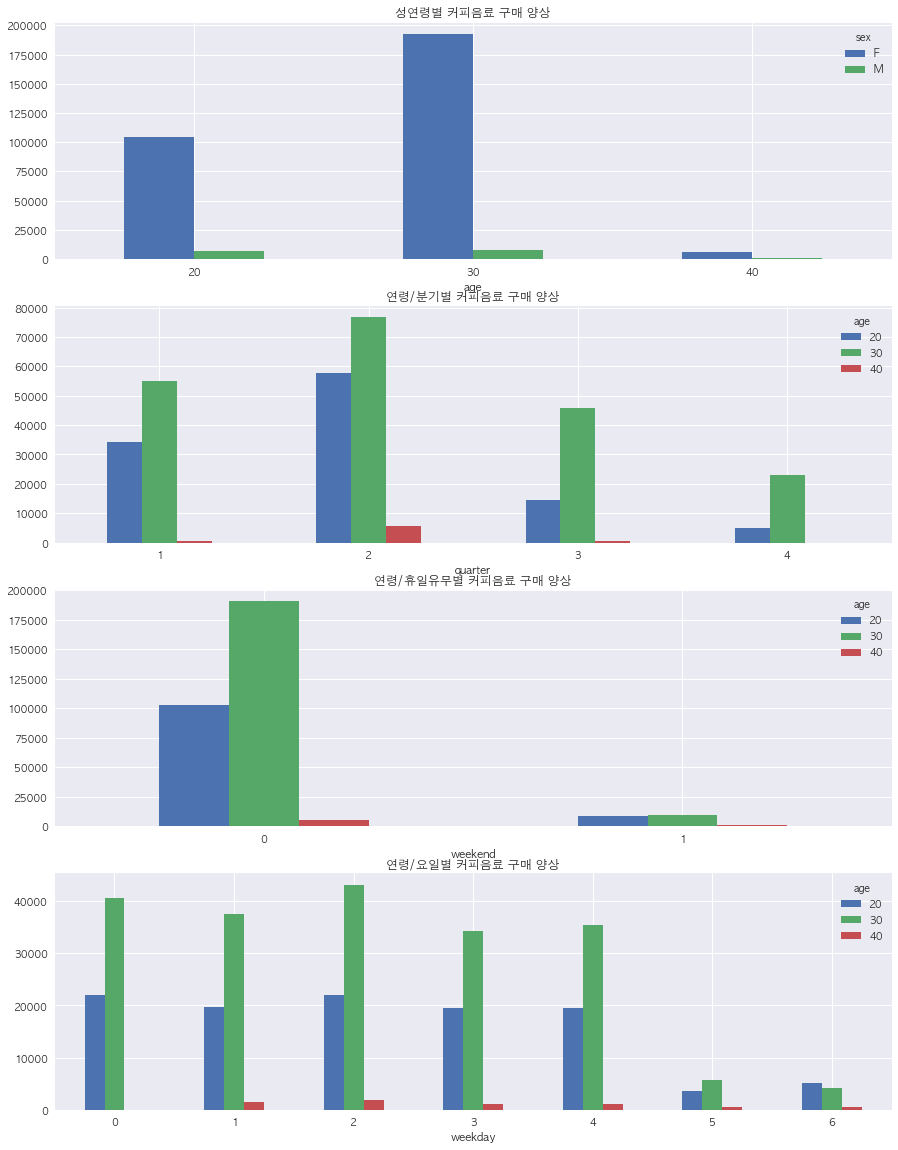

In [125]:
f, ax = plt.subplots(4, 1, figsize=(15,20))
qty_over[qty_over['sm_cat'] == '커피음료'].groupby(['age', 'sex']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[0])
qty_over[qty_over['sm_cat'] == '커피음료'].groupby(['quarter', 'age']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[1])
qty_over[qty_over['sm_cat'] == '커피음료'].groupby(['weekend', 'age']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[2])
qty_over[qty_over['sm_cat'] == '커피음료'].groupby(['weekday', 'age']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[3])

ax[0].set_title('성연령별 커피음료 구매 양상')
ax[1].set_title('연령/분기별 커피음료 구매 양상')
ax[2].set_title('연령/휴일유무별 커피음료 구매 양상')
ax[3].set_title('연령/요일별 커피음료 구매 양상')

plt.show()

#### (3) 생수

In [126]:
qty_over[qty_over['sm_cat'] == '생수'].sort_values("qty", ascending=False).head()

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
1379759,2019-05-10,F,30,식품,생수,1742,37.805675,2019,5,10,2,4,0,0,0
1414643,2019-05-22,F,30,식품,생수,1585,44.288064,2019,5,22,2,2,0,0,0
389641,2018-05-22,F,30,식품,생수,1561,35.448670,2018,5,22,2,1,1,0,0
1373739,2019-05-08,F,30,식품,생수,1490,40.829110,2019,5,8,2,2,0,0,0
1356246,2019-05-02,F,30,식품,생수,1419,37.896996,2019,5,2,2,3,0,0,0


In [128]:
# 성연령별 생수 구매 
qty_over[qty_over['sm_cat'] == '생수'].groupby(['age', 'sex']).qty.sum().unstack()

sex,F,M
age,,
20,8260,504
30,118229,10576
40,49654,5973
50,1812,4931


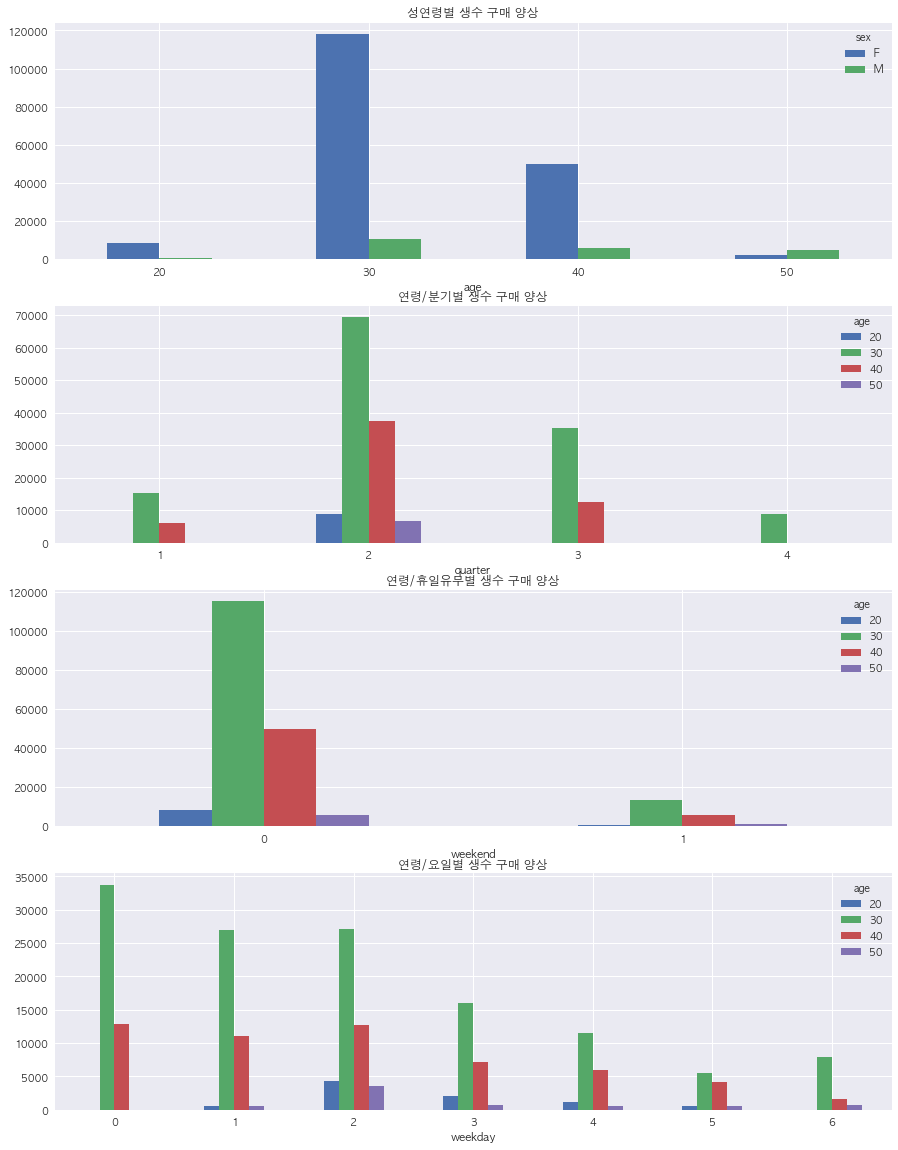

In [129]:
f, ax = plt.subplots(4, 1, figsize=(15,20))
qty_over[qty_over['sm_cat'] == '생수'].groupby(['age', 'sex']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[0])
qty_over[qty_over['sm_cat'] == '생수'].groupby(['quarter', 'age']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[1])
qty_over[qty_over['sm_cat'] == '생수'].groupby(['weekend', 'age']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[2])
qty_over[qty_over['sm_cat'] == '생수'].groupby(['weekday', 'age']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[3])

ax[0].set_title('성연령별 생수 구매 양상')
ax[1].set_title('연령/분기별 생수 구매 양상')
ax[2].set_title('연령/휴일유무별 생수 구매 양상')
ax[3].set_title('연령/요일별 생수 구매 양상')

plt.show()

## 2. cnt 

In [130]:
# Q3 까지 40 ...
df[['cnt']].describe()

,cnt
count,2056899.000000
mean,45.161592
std,121.547097
min,0.000000
25%,2.598891
50%,10.633134
75%,40.898771
max,2248.387367


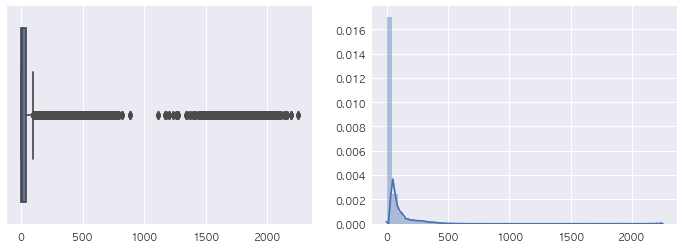

In [131]:
# qty 분포 : 당연하게도 왼쪽에 매우 매우 몰려 있음 ~ 
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(df[['cnt']], ax=ax1)
sns.distplot(df[['cnt']], ax=ax2)

plt.show()

In [133]:
# 도대체 뭐가 그렇게 이슈였을까 ~ : 오이/가지 ...???!!! 
df.sort_values("cnt", ascending=False).drop_duplicates('cnt').head(20)

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
1593415,2019-07-23,F,40,식품,오이/가지,33,2248.387367,2019,7,23,3,1,0,0,1
1596338,2019-07-24,M,60,식품,오이/가지,3,2195.046100,2019,7,24,3,2,0,0,1
546973,2018-07-18,F,50,식품,오이/가지,7,2163.927347,2018,7,18,3,2,0,0,1
1573407,2019-07-16,F,60,식품,오이/가지,2,2156.198967,2019,7,16,3,1,0,0,1
1576345,2019-07-17,F,50,식품,오이/가지,6,2136.378300,2019,7,17,3,2,0,0,1
1570457,2019-07-15,M,60,식품,오이/가지,1,2112.634633,2019,7,15,3,0,0,0,1
549724,2018-07-19,F,30,식품,오이/가지,10,2100.848750,2018,7,19,3,3,0,0,1
1356687,2019-05-02,M,40,식품,오이/가지,22,2090.719833,2019,5,2,2,3,0,0,0
1599241,2019-07-25,F,50,식품,오이/가지,10,2082.076333,2019,7,25,3,3,0,0,1
544116,2018-07-17,F,60,식품,오이/가지,1,2076.494567,2018,7,17,3,1,0,0,1


In [134]:
# 또 다른 이슈 체크 (공청기 보임 but 오이 넘사 ..)
df.sort_values("cnt", ascending=False).drop_duplicates('sm_cat').head(20)

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
1593415,2019-07-23,F,40,식품,오이/가지,33,2248.387367,2019,7,23,3,1,0,0,1
1185783,2019-03-05,F,30,냉난방가전,공기청정기,640,884.439607,2019,3,5,1,1,0,0,0
223415,2018-03-11,F,40,식품,딸기/복분자/블루베리,19,819.687947,2018,3,11,1,6,0,1,0
479242,2018-06-24,F,30,식품,기타 한방/환제품,4,799.814223,2018,6,24,2,6,0,1,1
481401,2018-06-24,M,20,냉난방가전,히터,2,778.778307,2018,6,24,2,6,0,1,1
901742,2018-11-25,M,30,식품,김치류,30,775.172233,2018,11,25,4,6,0,1,2
885197,2018-11-19,F,40,식품,무/배추,6,692.773387,2018,11,19,4,0,0,0,2
492982,2018-06-29,F,30,식품,계란,69,601.630140,2018,6,29,2,4,0,0,1
1533795,2019-07-02,F,20,식품,파/양파,11,586.297557,2019,7,2,3,1,0,0,1
710176,2018-09-16,M,50,식품,새우/대하,3,577.289910,2018,9,16,3,6,0,1,2


### 1) 오이/가지 

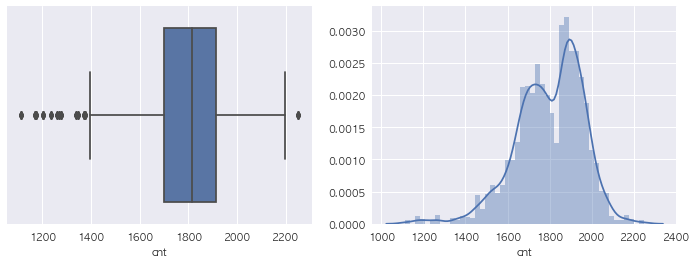

In [135]:
# 오이/가지 cnt : 항상 많이 언급 되는 듯 
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(df[df["sm_cat"] == '오이/가지'].cnt, ax=ax1)
sns.distplot(df[df["sm_cat"] == '오이/가지'].cnt, ax=ax2)

plt.show()

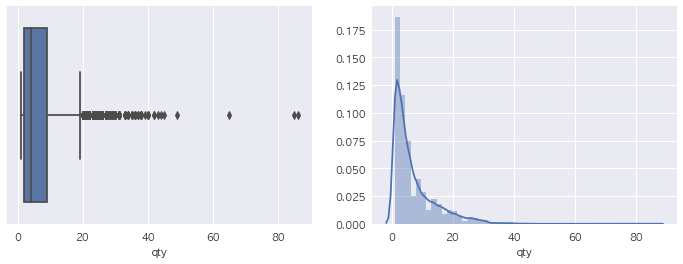

In [136]:
# 오이/가지 qty : 언급은 많이 되는데 생각보다 구매를 많이 하는 것 같지는 않음 
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(df[df["sm_cat"] == '오이/가지'].qty, ax=ax1)
sns.distplot(df[df["sm_cat"] == '오이/가지'].qty, ax=ax2)

plt.show()

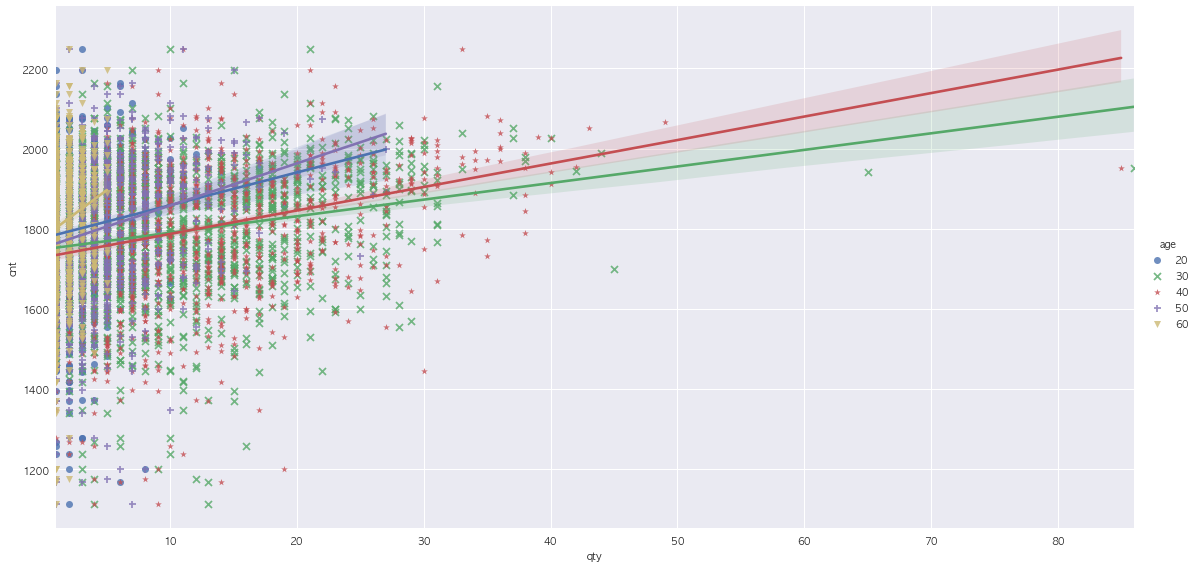

In [149]:
# 과연 상관관계 있는 것일까 .. 
sns.lmplot(x='qty', y='cnt', hue='age', markers=['o','x','*','+','v'], 
           data = df[df["sm_cat"] == '오이/가지'], height=8, aspect=2)
plt.show()

In [152]:
df[df["sm_cat"] == '오이/가지'][['qty', 'cnt']].corr()

,qty,cnt
qty,1.000000,0.152390
cnt,0.152390,1.000000


In [155]:
cucumber = df[df["sm_cat"] == '오이/가지'].reset_index(drop=True)
cucumber.shape

(5893, 15)

In [156]:
cucumber.head()

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
0,2018-01-01,F,20,식품,오이/가지,1,1530.353440,2018,1,1,1,0,1,0,3
1,2018-01-01,F,30,식품,오이/가지,8,1530.353440,2018,1,1,1,0,1,0,3
2,2018-01-01,F,40,식품,오이/가지,6,1530.353440,2018,1,1,1,0,1,0,3
3,2018-01-01,F,50,식품,오이/가지,1,1530.353440,2018,1,1,1,0,1,0,3
4,2018-01-01,M,20,식품,오이/가지,1,1530.353440,2018,1,1,1,0,1,0,3


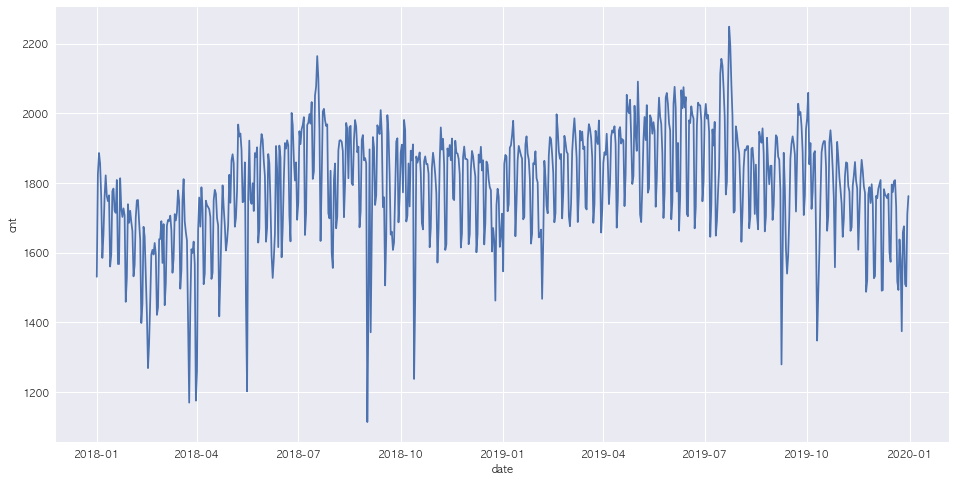

In [158]:
# 날짜에 따른 cnt 변화량 체크 
plt.subplots(figsize=(16,8))
sns.lineplot(x='date', y='cnt', data=cucumber.drop_duplicates('cnt'))

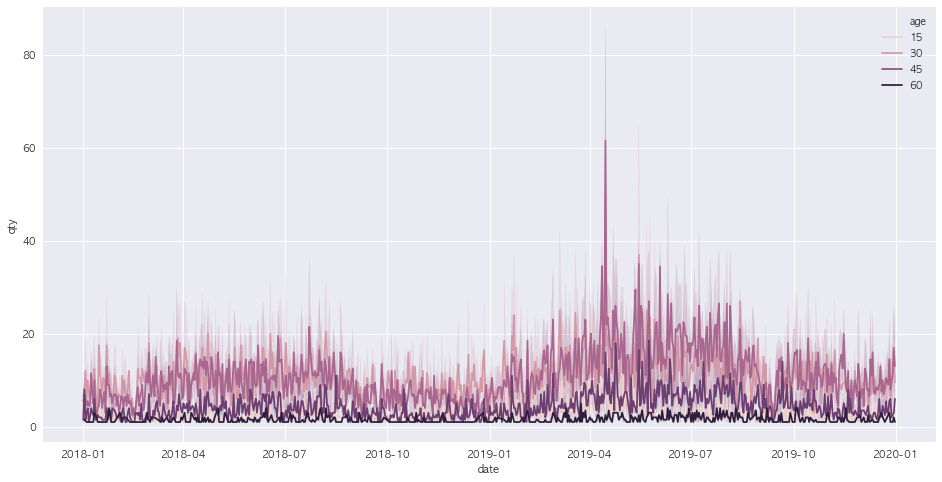

In [160]:
# 날짜/연령에 따른 qty 변화량 체크 
plt.subplots(figsize=(16,8))
sns.lineplot(x='date', y='qty', hue='age', data=cucumber)

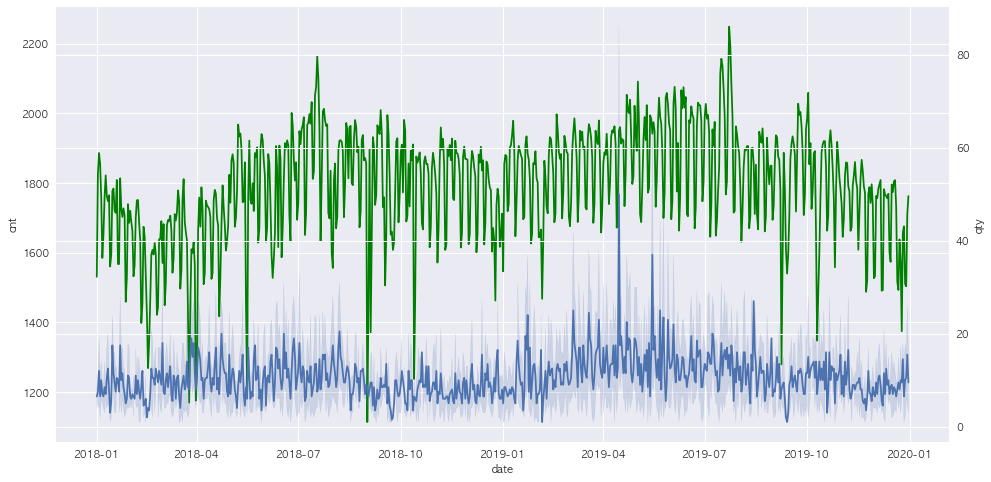

In [165]:
# 30대 
plt.subplots(figsize=(16,8))
sns.lineplot(x='date', y='cnt', data=cucumber[cucumber['age']==30], color='g')
ax2 = plt.twinx()
sns.lineplot(x='date', y='qty', data=cucumber[cucumber['age']==30], ax=ax2)

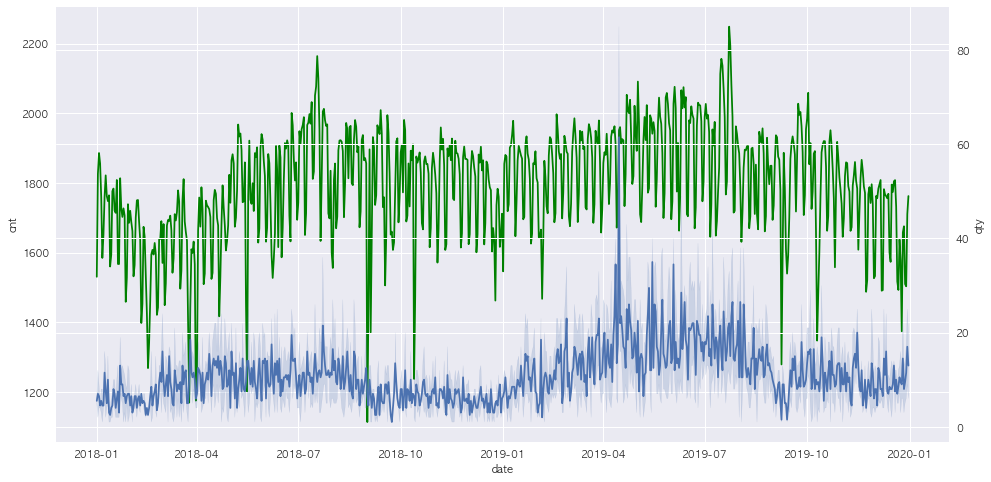

In [166]:
# 40대 
plt.subplots(figsize=(16,8))
sns.lineplot(x='date', y='cnt', data=cucumber[cucumber['age']==40], color='g')
ax2 = plt.twinx()
sns.lineplot(x='date', y='qty', data=cucumber[cucumber['age']==40], ax=ax2)

### (2) 공청기 

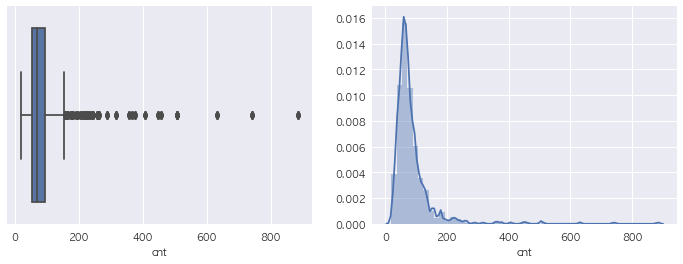

In [167]:
# cnt : 왼쪽으로 몰려있음 
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(df[df["sm_cat"] == '공기청정기'].cnt, ax=ax1)
sns.distplot(df[df["sm_cat"] == '공기청정기'].cnt, ax=ax2)

plt.show()

In [169]:
# 3월에 언급이 많이 됨 
df[df["sm_cat"] == '공기청정기'].sort_values('cnt', ascending=False).drop_duplicates('cnt').head(10)

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
1185782,2019-03-05,F,20,냉난방가전,공기청정기,218,884.439607,2019,3,5,1,1,0,0,0
1188757,2019-03-06,M,20,냉난방가전,공기청정기,107,741.968127,2019,3,6,1,2,0,0,0
237790,2018-03-26,M,50,냉난방가전,공기청정기,53,631.841732,2018,3,26,1,0,0,0,0
1191715,2019-03-07,F,40,냉난방가전,공기청정기,288,507.522513,2019,3,7,1,3,0,0,0
237792,2018-03-27,F,20,냉난방가전,공기청정기,42,506.192352,2018,3,27,1,1,0,0,0
1046028,2019-01-15,M,60,냉난방가전,공기청정기,21,458.423150,2019,1,15,1,1,0,0,3
1043042,2019-01-14,M,50,냉난방가전,공기청정기,62,447.393620,2019,1,14,1,0,0,0,3
1182777,2019-03-04,M,20,냉난방가전,공기청정기,49,407.398887,2019,3,4,1,0,0,0,0
237781,2018-03-25,M,60,냉난방가전,공기청정기,1,377.132539,2018,3,25,1,6,0,1,0
1194660,2019-03-08,M,50,냉난방가전,공기청정기,115,365.201730,2019,3,8,1,4,0,0,0


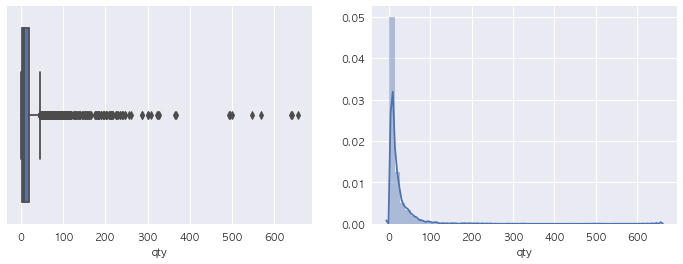

In [168]:
# 오이/가지 qty : cnt 랑 분포가 비슷 
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(df[df["sm_cat"] == '공기청정기'].qty, ax=ax1)
sns.distplot(df[df["sm_cat"] == '공기청정기'].qty, ax=ax2)

plt.show()

In [171]:
# 많이 팔린 날짜도 3월이 대부분 + 1월... 
df[df["sm_cat"] == '공기청정기'].sort_values('qty', ascending=False).drop_duplicates('cnt').head(10)

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
1188754,2019-03-06,F,40,냉난방가전,공기청정기,655,741.968127,2019,3,6,1,2,0,0,0
1185783,2019-03-05,F,30,냉난방가전,공기청정기,640,884.439607,2019,3,5,1,1,0,0,0
1194654,2019-03-08,F,40,냉난방가전,공기청정기,367,365.201730,2019,3,8,1,4,0,0,0
1191714,2019-03-07,F,30,냉난방가전,공기청정기,364,507.522513,2019,3,7,1,3,0,0,0
237793,2018-03-27,F,30,냉난방가전,공기청정기,323,506.192352,2018,3,27,1,1,0,0,0
237783,2018-03-26,F,30,냉난방가전,공기청정기,301,631.841732,2018,3,26,1,0,0,0,0
1200299,2019-03-10,F,40,냉난방가전,공기청정기,300,225.437630,2019,3,10,1,6,0,1,0
1182773,2019-03-04,F,30,냉난방가전,공기청정기,256,407.398887,2019,3,4,1,0,0,0,0
1179931,2019-03-03,F,30,냉난방가전,공기청정기,246,219.519140,2019,3,3,1,6,0,1,0
1046020,2019-01-15,F,30,냉난방가전,공기청정기,239,458.423150,2019,1,15,1,1,0,0,3


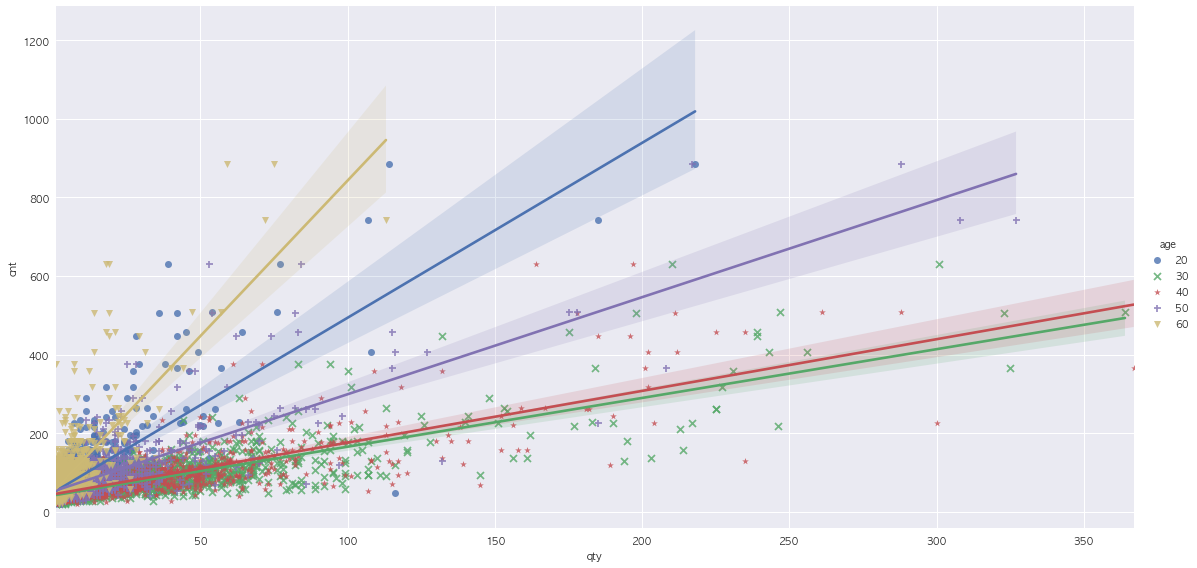

In [175]:
# 기울기가 가장 큰 연령대는 60대 
sns.lmplot(x='qty', y='cnt', hue='age', markers=['o','x','*','+','v'], 
           data = df[(df["sm_cat"] == '공기청정기') & (df["qty"]<400)], height=8, aspect=2)
plt.show()

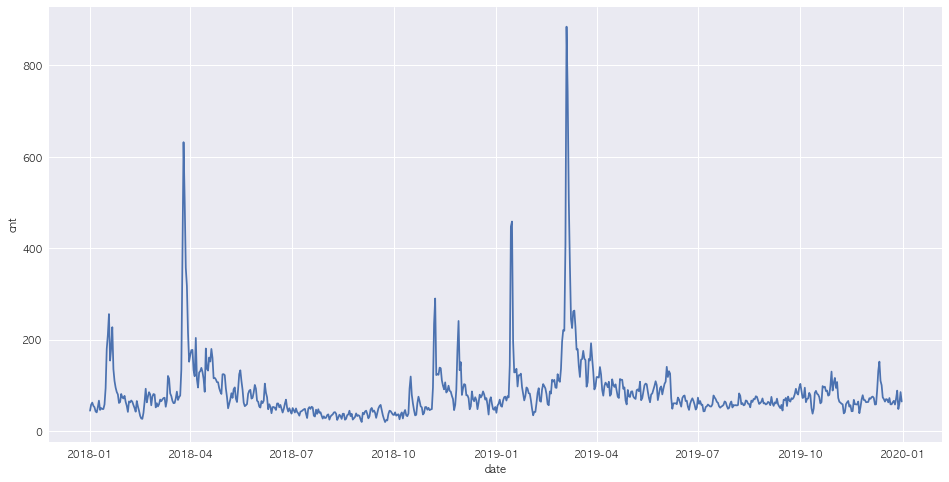

In [176]:
# 날짜에 따른 cnt 변화량 체크 : 언급이 많았던 봄 
plt.subplots(figsize=(16,8))
sns.lineplot(x='date', y='cnt', data=df[df["sm_cat"] == '공기청정기'].drop_duplicates('cnt'))

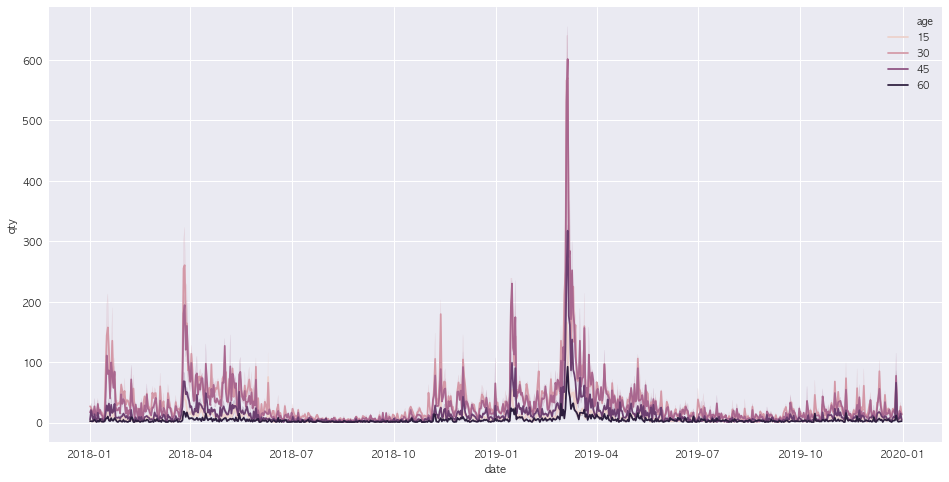

In [177]:
# 날짜/연령에 따른 qty 변화량 체크 : 언급량이랑 구매량 비슷한 양상을 보임 
plt.subplots(figsize=(16,8))
sns.lineplot(x='date', y='qty', hue='age', data=df[df["sm_cat"] == '공기청정기'])

In [178]:
# 상관관계 엄청 높음! 
df[df["sm_cat"] == '공기청정기'][['qty', 'cnt']].corr()

,qty,cnt
qty,1.000000,0.664421
cnt,0.664421,1.000000


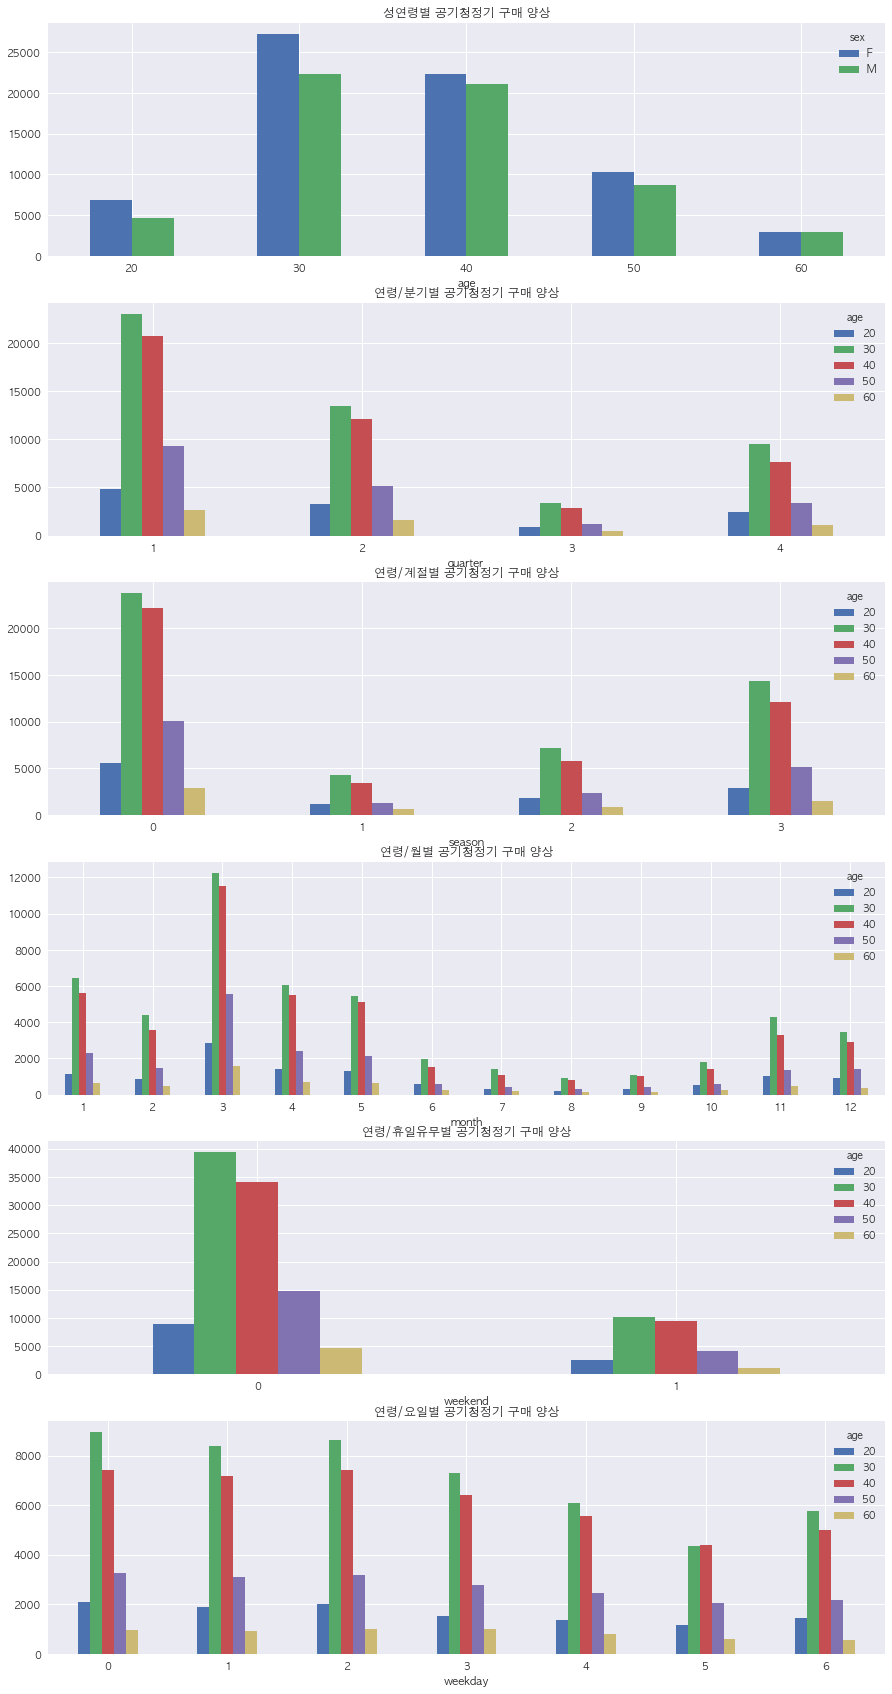

In [182]:
# 계절 가전 .. 공청기 .. 
f, ax = plt.subplots(6, 1, figsize=(15,30))
df[df['sm_cat'] == '공기청정기'].groupby(['age', 'sex']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[0])
df[df['sm_cat'] == '공기청정기'].groupby(['quarter', 'age']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[1])
df[df['sm_cat'] == '공기청정기'].groupby(['season', 'age']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[2])
df[df['sm_cat'] == '공기청정기'].groupby(['month', 'age']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[3])
df[df['sm_cat'] == '공기청정기'].groupby(['weekend', 'age']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[4])
df[df['sm_cat'] == '공기청정기'].groupby(['weekday', 'age']).qty.sum().unstack().plot.bar(rot = 0, ax = ax[5])

ax[0].set_title('성연령별 공기청정기 구매 양상')
ax[1].set_title('연령/분기별 공기청정기 구매 양상')
ax[2].set_title('연령/계절별 공기청정기 구매 양상')
ax[3].set_title('연령/월별 공기청정기 구매 양상')
ax[4].set_title('연령/휴일유무별 공기청정기 구매 양상')
ax[5].set_title('연령/요일별 공기청정기 구매 양상')

plt.show()

## 3. Feature 별로 많이 구매한 품목 살펴보기 

### 1. 연령 

In [184]:
df.head()

,date,sex,age,big_cat,sm_cat,qty,cnt,year,month,day,quarter,weekday,isHoliday,weekend,season
0,2018-01-01,F,20,식품,가공란,37,0.480964,2018,1,1,1,0,1,0,3
1,2018-01-01,F,30,식품,가공란,16,0.480964,2018,1,1,1,0,1,0,3
2,2018-01-01,F,40,식품,가공란,9,0.480964,2018,1,1,1,0,1,0,3
3,2018-01-01,F,50,식품,가공란,3,0.480964,2018,1,1,1,0,1,0,3
4,2018-01-01,M,20,식품,가공란,13,0.480964,2018,1,1,1,0,1,0,3


In [200]:
df_age = df.groupby(['age', 'big_cat', 'sm_cat']).agg({
    'qty' : [("total_qty", np.sum)] , 
    'cnt' : [("mean_cnt", np.mean)]
}).reset_index()

df_age.columns = df_age.columns.get_level_values(level=1)
df_age.columns = ['age', 'big_cat', 'sm_cat', 'total_qty', 'mean_cnt']`

In [201]:
df_age

,age,big_cat,sm_cat,total_qty,mean_cnt
0,20,냉난방가전,가스온수기,7,0.954941
1,20,냉난방가전,가열식 가습기,439,4.397984
2,20,냉난방가전,공기정화 용품,13755,2.479426
3,20,냉난방가전,공기청정기,11501,86.798485
4,20,냉난방가전,난방용 열풍기,11,0.303815
...,...,...,...,...,...
1908,60,식품,홍어,546,19.986220
1909,60,식품,홍차,993,32.573815
1910,60,식품,환자식,3666,0.713477
1911,60,식품,회,18164,262.833244


In [203]:
df_age[df_age["age"] == 20].sort_values('total_qty', ascending=False).head(20)

,age,big_cat,sm_cat,total_qty,mean_cnt
345,20,식품,커피음료,437775,1.677123
52,20,뷰티,기초 화장용 크림,359707,81.190173
381,20,식품,회,284362,262.845045
237,20,식품,돼지 곱창,268873,9.791852
276,20,식품,생수,212444,40.874600
123,20,뷰티,샴푸,165581,122.249750
340,20,식품,카페 푸드,142213,119.412777
233,20,식품,닭가슴살,139393,88.724135
50,20,뷰티,기초 화장용 에센스,136045,70.957294
133,20,뷰티,스킨케어 마스크팩,120173,55.013792


In [204]:
df_age[df_age["age"] == 30].sort_values('total_qty', ascending=False).head(20)

,age,big_cat,sm_cat,total_qty,mean_cnt
435,30,뷰티,기초 화장용 크림,586352,81.190173
728,30,식품,커피음료,511889,1.677123
659,30,식품,생수,477144,40.874600
764,30,식품,회,381745,262.845045
506,30,뷰티,샴푸,371490,122.249750
620,30,식품,돼지 곱창,296138,9.791852
765,30,식품,흰우유,250186,5.374921
433,30,뷰티,기초 화장용 에센스,247804,70.957294
705,30,식품,인스턴트커피,220531,2.204977
670,30,식품,쌀,218936,145.859827


In [205]:
df_age[df_age["age"] == 40].sort_values('total_qty', ascending=False).head(20)

,age,big_cat,sm_cat,total_qty,mean_cnt
818,40,뷰티,기초 화장용 크림,446639,81.190173
1042,40,식품,생수,385642,40.874600
889,40,뷰티,샴푸,346427,122.249750
1053,40,식품,쌀,259708,145.859827
1111,40,식품,커피음료,254485,1.677123
1088,40,식품,인스턴트커피,232987,2.204977
816,40,뷰티,기초 화장용 에센스,230033,70.957294
943,40,식품,감귤/한라봉/오렌지,220307,189.786012
1147,40,식품,회,215768,262.845045
1004,40,식품,두유,208940,39.811094


In [206]:
df_age[df_age["age"] == 50].sort_values('total_qty', ascending=False).head(20)

,age,big_cat,sm_cat,total_qty,mean_cnt
1425,50,식품,생수,210482,40.874600
1201,50,뷰티,기초 화장용 크림,183518,81.190173
1272,50,뷰티,샴푸,143050,122.249750
1436,50,식품,쌀,133820,145.859827
1471,50,식품,인스턴트커피,129179,2.204977
1387,50,식품,두유,117093,39.811094
1326,50,식품,감귤/한라봉/오렌지,100564,189.804838
1199,50,뷰티,기초 화장용 에센스,98792,70.957294
1417,50,식품,비타민,83023,202.368220
1508,50,식품,프로바이오틱스,81706,11.510368


# TimeSeries Clustering 

In [210]:
from tslearn.clustering import TimeSeriesKMeans

In [218]:
df_cat = df.groupby(['date', 'big_cat', 'sm_cat']).sum('qty').reset_index()[["date", "sm_cat", "qty"]]

In [219]:
df_cat.groupby('sm_cat')

,date,sm_cat,qty
0,2018-01-01,가열식 가습기,7
1,2018-01-01,공기정화 용품,120
2,2018-01-01,공기청정기,106
3,2018-01-01,냉풍기,1
4,2018-01-01,돈풍기,2
...,...,...,...
267702,2019-12-31,홍어,7
267703,2019-12-31,홍차,50
267704,2019-12-31,환자식,69
267705,2019-12-31,회,2459


In [ ]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw",
                         max_iter=10, random_state=seed)
model.fit(X_train)